# ДЗ №5
## Обучение свёрточной нейронной сети на PyTorch

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# os.environ 

In [3]:
# !pip install torch torchvision numpy matplotlib

В этом задании нужно решить задачу классификации рукописных цифр с использованием сверточной нейронной сети, написанной на **PyTorch**.

In [4]:
import torch
from torchvision import models

import torchvision
import numpy as np


from typing import Tuple, List, Type, Dict, Any

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
 
%matplotlib inline

import matplotlib.pyplot as plt


Как и в ДЗ №3, можно зафиксировать генератор случайных чисел.

Подробнее: https://pytorch.org/docs/stable/notes/randomness.html

In [5]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Модель

В отличие от ДЗ №3, где использовались в-основном модули `torch.nn.Linear`, в этот раз модель будет состоять из модулей `torch.nn.Conv2d`, `torch.nn.MaxPool2d` и других слоев, которые обсуждались на лекциях в контексте сверточных сетей.

Так же, как в ДЗ №3, класс вашей нейросетевой модели может быть описан как модуль, наследуемый от `torch.nn.Module`, в котором реализуются методы `.forward` и (при необходимости) `.backward`.

### Задание 1
(20 баллов)


Реализуйте многослойную сверточную нейронную сеть по аналогии с AlexNet или VGG на **Pytorch**. Желательно, чтобы реализация модели имела параметризуемую глубину (количество слоёв), количество параметров на каждом слое и функцию активации. Отсутствие такой возможности не снижает балл, но сильно поможет в освоении принципов построения нейросетей с применением библиотеки `pytorch`.

In [6]:
class ConvNet(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 filters_shape: List[List[int]] = [[16,  3, 3],
                                                   [64,  3, 3],
                                                   [128, 3, 3]],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):
        super(ConvNet, self).__init__()
        self.model = models.vgg16(pretrained=False)
        
    #self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.model.classifier[6] = torch.nn.Linear(self.model.classifier[6].in_features, 10)
          
    def forward(self, x):
        out = self.model(x)
        return out

Следующий код позволяет посмотреть архитектуру получившейся модели и общее количество обучаемых параметров. Мы хотим, чтобы количество параметров в модели было порядка сотен тысяч. Если у вас получается больше или меньше, попробуйте изменить архитектуру модели.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [8]:
model = ConvNet().to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

ConvNet(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

### Обучающая выборка

По аналогии с ДЗ №3 следует подготовить данные набор рукописных цифр MNIST.

Здесь можно вспомнить о том, что сама по себе операция свертки не обладает инвариантностью к повороту. Однако в некоторой степени этой инвариантности сеть можно "обучить", предоставляя для тренировки примеры, предварительно повернутые на разные углы. Остальные методы предобработки и искусственного дополнения (аугментации) данных, которые были применены в ДЗ №3 для многослойного перцептрона, по-прежнему могут быть применены и для сверточных сетей.

Подробнее можно почитать здесь:<br />
http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf<br />
https://link.springer.com/content/pdf/10.1186/s40537-019-0197-0.pdf

### Задание 2, 3

(по 15 баллов)

Предложите обоснуйте (опишите текстом - задание 2) и реализуйте (в виде трансформаций в коде ниже - задание 3) осмысленные аугментации, потенциально повышающие обобщающую способность сверточной сети в задаче распознавания (классификации) рукописных цифр набора данных MNIST.

В реализации трансформаций не забудьте, что, по прежнему, одним из обязательных шагов в вашем пайплайне обработки данных должна быть конвертация данных в тензоры Pytorch (`torch.Tensor`): `torchvision.transforms.ToTensor()`.

Не забудьте, что признаковое описание объектов в этой задаче должно остаться тензорами ранга 2 (матрицы 28x28)

In [9]:
# Вертикальный и горизонтальный флип, потому что некоторые числа надо уметь распознавать даже при отражении.
# Вращение на случайных угол, чтобы справиться с углом поворота чисел. 

In [10]:
train_transforms = torchvision.transforms.Compose([  # your core here
   #  
    torchvision.transforms.CenterCrop((32, 32)),
    # torchvision.transforms.RandomChoice(transforms = [torchvision.transforms.RandomRotation(degrees = (-70, 60)), 
    #                                       torchvision.transforms.RandomRotation(degrees = 360)
    #                                       ]),

    torchvision.transforms.RandomRotation(degrees = (-10, 5)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((32, 32)),                                             
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms) 

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms) 
train_dataset.data.shape

torch.Size([60000, 28, 28])

Перед тем как запускать обучение всегда стоит посмотреть на данные после предобработки, и удостовериться, что они соответствуют ожидаемым

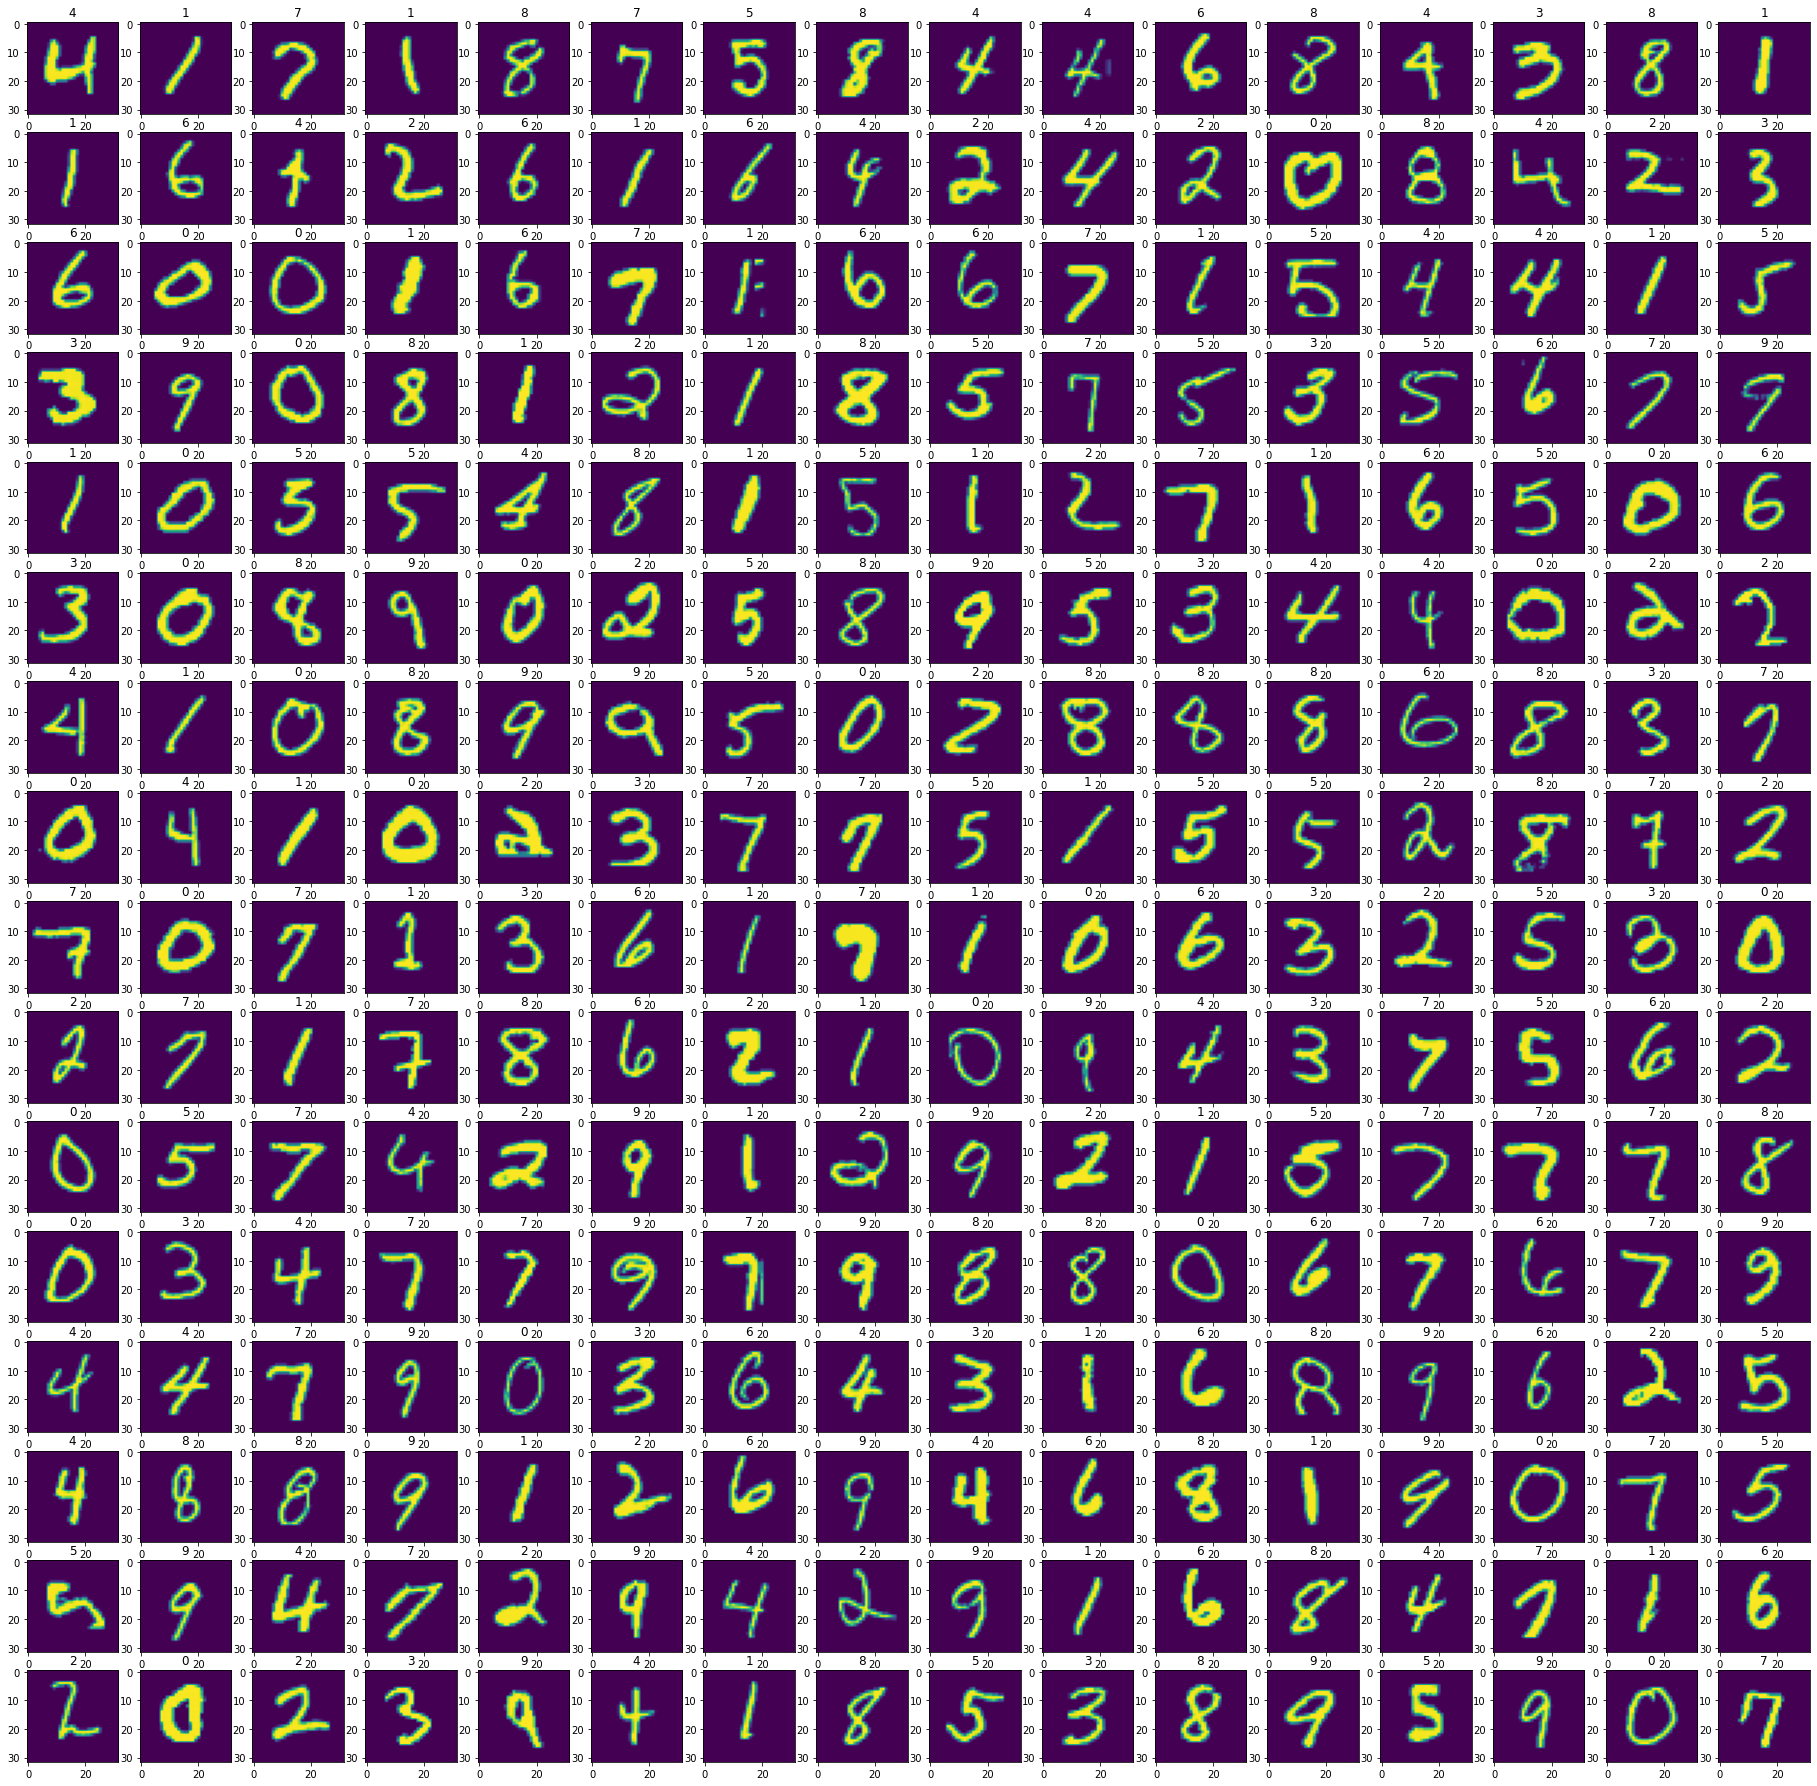

In [12]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        #print(sample.shape)
        ax.imshow(sample[0,:,:].cpu().numpy()) #.squeeze(0)
        ax.set_title(label)
        

### Обучение модели

Теперь, когда мы реализовали модель и подготовили данные мы можем приступить к непосредственному обучению модели. Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [13]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 50,
                early_stopping_patience = 20):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    epoch_train_losses = []
    
    #pbar = tqdm(total=max_epochs)
    for epoch in range(max_epochs) :
        
        print(f'Epoch {epoch}')
        loss_train = train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### Задание 4
(15 баллов)

Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`. При итерировании по `data_loader` вы будете получать пары вида ( данные, целевая_переменная )

In [14]:
from tqdm import tqdm 


def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       data_loader: torch.utils.data.DataLoader):
  model.train()
  for data, target in tqdm(data_loader):

    optimizer.zero_grad()
    data = data.to(device)
    target = target.to(device)
    preds = model.forward(data)

    loss = loss_function(preds, target) 
    loss.backward()
 
    optimizer.step()
  return 0
    #raise NotImplementedError

### Задание 5
(15 баллов)

Реализуйте функцию производящую вычисление функции потерь на валидационной выборке.  На вход будет приходить модель, функция потерь и `DataLoader`. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [15]:
from sklearn.metrics import accuracy_score

def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    results = {}
    losses = []
    accuracies = []
    for data, target in data_loader:

      data = data.to(device)
      target = target.to(device)
      preds = model.forward(data)
      
      loss = loss_function(preds, target).data.cpu()
      accuracy = (preds.argmax(dim=1)==target).float().mean().data.cpu()
       
      
      losses.append(loss)
      accuracies.append(accuracy)

    results['loss'] = np.mean(losses)
    results['accuracy'] = np.mean(accuracies)
    return results

    #raise NotImplementedError

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения, и мы должны достичь итоговой точности (в смысле меры accuracy, доли верных ответов) выше 90%

Вполне вероятно, что с использованием сверточной сети будет достигнуто качество, превышающее показатель многослойного перцептрона.

In [16]:
train_model(model,
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.001,
            max_epochs = 7,
            batch_size = 64,
            );

  0%|          | 2/938 [00:00<01:19, 11.70it/s]

Epoch 0


100%|██████████| 938/938 [01:35<00:00,  9.80it/s]


Validation metrics: 
{'loss': 0.18328813, 'accuracy': 0.9537221}
Best model yet, saving


  0%|          | 2/938 [00:00<01:24, 11.12it/s]

Epoch 1


100%|██████████| 938/938 [01:35<00:00,  9.82it/s]


Validation metrics: 
{'loss': 0.12560539, 'accuracy': 0.97790605}
Best model yet, saving


  0%|          | 2/938 [00:00<01:19, 11.78it/s]

Epoch 2


100%|██████████| 938/938 [01:35<00:00,  9.83it/s]


Validation metrics: 
{'loss': 0.103825636, 'accuracy': 0.9743233}
Best model yet, saving


  0%|          | 2/938 [00:00<01:23, 11.18it/s]

Epoch 3


100%|██████████| 938/938 [01:35<00:00,  9.83it/s]


Validation metrics: 
{'loss': 0.08911871, 'accuracy': 0.9839769}
Best model yet, saving


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


100%|██████████| 938/938 [01:35<00:00,  9.84it/s]


Validation metrics: 
{'loss': 0.087394185, 'accuracy': 0.9795979}
Best model yet, saving


  0%|          | 2/938 [00:00<01:21, 11.52it/s]

Epoch 5


  0%|          | 2/938 [00:00<00:59, 15.60it/s]

Validation metrics: 
{'loss': 0.089313224, 'accuracy': 0.9806927}
Epoch 6


100%|██████████| 938/938 [01:35<00:00,  9.86it/s]


Validation metrics: 
{'loss': 0.06624924, 'accuracy': 0.98676354}
Best model yet, saving


### Задание 6
(20 баллов)

Модифицируйте процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Модель должна оставаться сверточной нейронной сетью без разностных соединений. Для обучения разрешается использовать только набор данных MNIST. Процесс обучения вы можете изменять по собственному усмотрению. К примеру, вы можете менять:

* Архитектуру модели в рамках наложенных ограничений на вид архитектуры
* Функции активации в модели
* Используемый оптимизатор
* Расписание шага оптимизации
* Сэмплинг данных при обучении ( e.g. hard negative mining)

В результате мы ожидаем увидеть код экспериментов и любые инсайты, которые вы сможете получить в процессе

In [17]:
scheduler = torch.optim.lr_scheduler.StepLR
 

In [18]:
train_model(model,
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.001,
            max_epochs = 7,
            lr_scheduler_class =  torch.optim.lr_scheduler.StepLR,
            lr_scheduler_params = {'step_size' : 7, 'gamma' : 0.1},
            batch_size = 256);

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


Validation metrics: 
{'loss': 0.054885775, 'accuracy': 0.98769534}
Best model yet, saving


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

Validation metrics: 
{'loss': 0.10322162, 'accuracy': 0.9771484}
Epoch 2


100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


Validation metrics: 
{'loss': 0.04931738, 'accuracy': 0.98876953}
Best model yet, saving


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3


100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


Validation metrics: 
{'loss': 0.042218823, 'accuracy': 0.99052733}
Best model yet, saving


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4


100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


Validation metrics: 
{'loss': 0.038651586, 'accuracy': 0.99179685}
Best model yet, saving


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/235 [00:00<?, ?it/s]

Validation metrics: 
{'loss': 0.047625095, 'accuracy': 0.9880859}
Epoch 6


100%|██████████| 235/235 [00:53<00:00,  4.39it/s]


Validation metrics: 
{'loss': 0.03857038, 'accuracy': 0.9904297}
Best model yet, saving


Так как изначально была выбрана достаточно сильная модель и хорошая агментация (случайное вращение на определенный угол в диапазоне [-10,5] градусов), то уже на первых эпохах модель показывает высокую точности > 98% . 


Для финального улучшения, был выбран альтернативный алгоритм изменения `lr`, а именно `StepRL`. Можно заметить, что качество повышается ( > 99%), что говорит об успешном выборе алгоритма и архитектуры. 